While all the Pauli strings generated using `PySCF` and `OpenFermion`, we use `Qiskit` to generate the circuit. We also use `TrotterQRTE()` in `qiskit_algorithms` package to do the trotterization. Given the fact that `Qiskit` uses different endienness than `PySCF` and `OpenFermion`, you will see sometimes we put `[::-1]` to mark adjustment.

In [1]:
import qiskit_algorithms
import qiskit
import pyscf
import openfermion
qiskit_algorithms.__version__, qiskit.__qiskit_version__,pyscf.__version__, openfermion.__version__

('0.2.1',
 {'qiskit': '0.46.0', 'qiskit-aer': '0.13.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': '0.7.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None},
 '2.4.0',
 '1.6.0')

In [2]:
import numpy as np
import scipy.linalg as sl
## ADAPT-GCM
try:
    import operator_pools
    import pyscf_helper
except:
    raise Except("See ReadMe. Please go to https://github.com/mayhallgroup/adapt-vqe/tree/master/src to download required files.")

## ADAPT-GCM
from adapt_gcm import *
from moles import *

This is a modified operator_pools.py by Muqing Zheng
This is a modified pyscf_helper.py by Muqing Zheng


/home/firepanda415/anaconda3/envs/quant/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


## ADAPT-GCM

The following example could require `mf.init_guess='atom'` in `init()` in `pyscf_helper.py` to converge.

In [3]:
## Option for the pool and GCM
mol = H4L5() # internuclear distance H-H=5.0 Ang

make_orth = False # If classically orthogonalize the basis vector set
theta = np.pi/4 # constant phase parameter for all basis vectors

mol.initialize()
mol_name = mol.mol_name
mol_name_pic = mol.mol_name_pic
n_orb = mol.n_orb
n_a = mol.n_a
n_b = mol.n_b
fermi_ham = mol.fermi_ham
reference_ket = mol.reference_ket
file_prefix = 'H4L5_Demo_Data/'

 ---------------------------------------------------------
                                                          
                      Using Pyscf:
                                                          
 ---------------------------------------------------------
                                                          
Choosing unit Angstrom
SCF not converged.
SCF energy = -0.497861057393689
converged SCF energy = -1.19805014612773

System and Method:
[('H', (0, 0, 0)), ('H', (5, 0, 0)), ('H', (10, 0, 0)), ('H', (15, 0, 0))]
Basis set                                      :      sto-3g
Number of Orbitals                             :         4
Number of electrons                            :         4
Nuclear Repulsion                              :    0.4586202495 
Electronic SCF energy                          :   -1.6566703956 
SCF Energy                                     :   -1.1980501461
 AO->MO
 NElectrons:    2    2
 ecore:   0.00000000
 ERIs in the active-space:
(4, 4

## Use Qubit-ADAPT pool

In [4]:
## Muqing: Implement pool for Qubit-ADAPT-VQE
## Reference: https://github.com/JordanovSJ/VQE/blob/78ff043c2487b379ba2d4d89af1347988ebccebd/scripts/iter_vqe/qubit_adapt_vqe.py
##            https://github.com/JordanovSJ/VQE/blob/78ff043c2487b379ba2d4d89af1347988ebccebd/src/ansatz_element_sets.py#L134
import itertools
from operator_pools import OperatorPool
class pauli_exc(OperatorPool):
    def xyreplace(self, rstr):
        temp_str = rstr.replace('Y', 'A')
        X2Y_str = temp_str.replace('X', 'Y')
        Y2X_str = X2Y_str.replace('A', 'X')
        return Y2X_str
    
    def generate_SQ_Operators(self):
        print(" Form Pauli excitation operators")
        total_strs = []
        self.fermi_ops = []
        ### single_excitation_elements
        ## SQExc(i, j).excitations_generators https://github.com/JordanovSJ/VQE/blob/78ff043c2487b379ba2d4d89af1347988ebccebd/src/ansatz_element_sets.py#L152
        for i, j in itertools.combinations(range(self.n_spin_orb), 2):
            termA  = (  0.5*QubitOperator('X{:d}'.format(i))+0.5j*QubitOperator('Y{:d}'.format(i))  )
            termA *= (  0.5*QubitOperator('X{:d}'.format(j))-0.5j*QubitOperator('Y{:d}'.format(j))  )
            termA -= hermitian_conjugated(termA)
            
            ## To individual Pauli string
            for pt in termA.terms.keys():
                temp_op = 1j*QubitOperator(pt)
                if temp_op.action_strings.count('Y')%2 == 1:## Muqing: only include odd Y's
                    if self.xyreplace( str(temp_op) ) not in total_strs:
                        total_strs.append( str(temp_op) )
                        self.fermi_ops.append( temp_op )
                
        ### Double excitations
        ## DQExc([i, j], [k, l]).excitations_generators https://github.com/JordanovSJ/VQE/blob/78ff043c2487b379ba2d4d89af1347988ebccebd/src/ansatz_element_sets.py#L177
        for i, j, k, l in itertools.combinations(range(self.n_spin_orb), 4):
            termB = QubitOperator('')
            for q1, q2 in zip([i,j], [k,l]):
                termB *= (  0.5*QubitOperator('X{:d}'.format(q1))+0.5j*QubitOperator('Y{:d}'.format(q1))  )
                termB *= (  0.5*QubitOperator('X{:d}'.format(q2))-0.5j*QubitOperator('Y{:d}'.format(q2))  )
            termB -= hermitian_conjugated(termB)
            
            ## To individual Pauli string
            for pt in termB.terms.keys():
                temp_op = 1j*QubitOperator(pt)
                if temp_op.action_strings.count('Y')%2 == 1:## Muqing: only include odd Y's
                    if self.xyreplace( str(temp_op) ) not in total_strs:
                        total_strs.append( str(temp_op) )
                        self.fermi_ops.append( temp_op )

        self.n_ops = len(self.fermi_ops)
        print(" Number of operators: ", self.n_ops)
        return

In [5]:
pool = pauli_exc()
pool.init(n_orb, n_occ_a=n_a, n_occ_b=n_b, n_vir_a=n_orb-n_a, n_vir_b=n_orb-n_b)

 Form Pauli excitation operators
 Number of operators:  308


In [6]:
[GCM_EVS,OneShot_EV, GCM_Indices, GCM_DIFFS, OneShot_Diff, GCM_BASIS_SIZE] = adapt_gcm(fermi_ham, 
                                pool,  reference_ket, theta,
                                change_tol    = 1e-6,
                                max_iter = 3,
                                make_orth = make_orth,
                                file_prefix  = file_prefix)

 Generate Sparse Matrices for operators in pool


------------ Iter 0 Start ------------
 Sum of gradients = 1.892872
 Largest gradient = 0.343224

 Choose ansatz 268
 Number of saved prod bases 0 , H matrix size (2, 2)
   Eigensolver: dimension reduced from 2 to 2, with eigval > 1.000e-14
 GCM Energy:  -1.345019003722381
 GCM error : 5.213085e-01
------------ Iter 0 Finish -----------


------------ Iter 1 Start ------------
 Sum of gradients = 1.862922
 Largest gradient = 0.352020

 Choose ansatz 108
 Number of saved prod bases 1 , H matrix size (4, 4)
   Eigensolver: dimension reduced from 4 to 4, with eigval > 1.000e-14
 GCM Energy:  -1.519103324773616
 GCM error : 3.472242e-01
------------ Iter 1 Finish -----------


------------ Iter 2 Start ------------
 Sum of gradients = 2.003761
 Largest gradient = 0.378503

 Choose ansatz 121
 Number of saved prod bases 2 , H matrix size (6, 6)
   Eigensolver: dimension reduced from 6 to 6, with eigval > 1.000e-14
 GCM Energy:  -1.8663273471

## Plot Errors

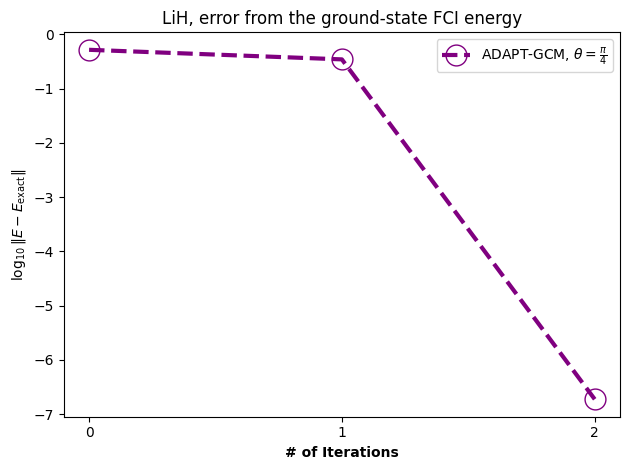

In [7]:
import matplotlib.pyplot as plt
iter_range = list(range( 0, len(GCM_DIFFS) ))
plt.plot(iter_range, np.log10(np.abs(GCM_DIFFS))[iter_range],
         marker='o',markerfacecolor='none',color='purple',
         linestyle='--',linewidth=3,markersize=15, label=r'ADAPT-GCM, $\theta = \frac{\pi}{4}$')
plt.xlabel(r'# of Iterations', fontweight='bold')
plt.ylabel(r'$\log_{10}\|E - E_{\rm exact}\|$')
plt.title('LiH, error from the ground-state FCI energy')
plt.legend()
plt.xticks(iter_range)
plt.tight_layout()
plt.show()

## Use Qiskit Primitive to Compute $H$ and $S$ in Iteration 2 (with only Single basis)

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit.quantum_info import Operator
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit import transpile

In [9]:
## Convert openfermion.ops.operators.qubit_operator.QubitOperator to Qiskit operator
def format_qubit_operator(qubit_op, n_qubits, real_coeff = False, inverse_order=False):
    # qubit_op: openfermion.ops.operators.qubit_operator.QubitOperator
    # n_qubits: int
    # return array of coeffs and array of paulis
    imaginary_flag = False
    coefs = []
    paulis = []
    for term, term_coef in qubit_op.terms.items():
        # Create a list of 'I' for all qubits
        formatted_term = ['I'] * n_qubits
        for qubit, pauli in term:
            try:
                formatted_term[qubit] = pauli
            except:
                print(qubit, pauli)
        if real_coeff:
            if term_coef != np.imag(term_coef):
                imaginary_flag = True
            term_coef = np.imag(term_coef)
        coefs.append(term_coef)
        if inverse_order:
            paulis.append(''.join(formatted_term)[::-1])
        else:
            paulis.append(''.join(formatted_term))
    return coefs, paulis, imaginary_flag

In [10]:
## Split Hamiltonian
ham_jw = of.transforms.jordan_wigner(fermi_ham)
ham_coefs, ham_paulis, ham_imag = format_qubit_operator(ham_jw, n_orb*2, real_coeff = False, inverse_order=False)
print("Number of Pauli strings in the Hamiltonian:", len(ham_paulis))

Number of Pauli strings in the Hamiltonian: 185


## Trotter all selected basis (Single basis only)

We only select bases selected from first 3 iterations. NOTE: in GCM, string `IIIIIIII` should always be in the selected ansatz list, so we have 4 bases in this case.

In [11]:
ansatz_indx = GCM_Indices[0:3]
ansatz_indx

[268, 108, 121]

We choose 268, 108, 121 three operators as the extra ansatz than `IIIIIIII`.

In [12]:
ansatz_circuits = {}
ansatz_circuits[-1] = QuantumCircuit(n_orb*2) ## For string IIIIIIII

for ind in ansatz_indx:
    jw_op = pool.fermi_ops[ind]
    ## To Qiskit Op
    op_coefs, op_paulis, if_imag = format_qubit_operator(jw_op, n_orb*2, real_coeff = True, inverse_order=True) ## WARNING: Inverse the order here
    qiskit_op = SparsePauliOp(op_paulis, coeffs=-1*np.array(op_coefs) )
    ## To exp
    final_time = np.pi*0.25
    # initial_state = Statevector(reference_ket.todense())
    initial_state = Statevector.from_label('0'*(n_orb*2))
    problem = TimeEvolutionProblem(qiskit_op, initial_state=initial_state, time=final_time)
    ## to circuit
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)
    ## 
    ansatz_circuits[ind] = result.evolved_state.copy()
    ## decompose circuit
    decompose_circuit = result.evolved_state.decompose(reps=2).decompose('disentangler_dg').decompose('multiplex1_reverse_dg')
    error = np.linalg.norm(Operator(decompose_circuit).reverse_qargs().data - ssl.expm( np.pi*0.25*pool.spmat_ops[ind]))
    if 'cx' in decompose_circuit.count_ops().keys():
        print("Indx", ind, "Number of CNOT gates: {:d}, with error {:.3e}".format(decompose_circuit.count_ops()['cx'], error))
    else:
        print("Indx", ind, "Number of CNOT gates: {:d}, with error {:.3e}".format(0, error))

Indx 268 Number of CNOT gates: 6, with error 1.447e-14
Indx 108 Number of CNOT gates: 6, with error 1.447e-14
Indx 121 Number of CNOT gates: 6, with error 1.510e-14


The trotterization error is minimal.

## Hadamard test circuit function

In [13]:
def form_hadu_gate(ansatz_dict,p,q,ham_pauli,basis_gates):
    pauli_str = ham_pauli
    circ_width = len(pauli_str)
    ## controlled U gate in Hadamard test
    haduq = QuantumRegister(circ_width)
    hadu = QuantumCircuit(haduq)
    ## Append right operator
    hadu.append(ansatz_dict[q], qargs=haduq)
    # hadu.barrier()
    ## Append Paulis
    for i in range(circ_width):
        if pauli_str[i] == 'X':
            hadu.x(i)
        elif pauli_str[i] == 'Y':
            hadu.y(i)
        elif pauli_str[i] == 'Z':
            hadu.z(i)
        elif pauli_str[i] == 'I':
            pass
        else:
            raise Exception("Not a Pauli gate: ", pauli_str[i])
    # hadu.barrier()
    ## Append left operator
    left_conj = transpile(ansatz_dict[p],basis_gates=basis_gates,seed_transpiler=7, optimization_level=0).to_gate().inverse()
    hadu.append(left_conj, qargs=haduq)
    return  hadu
    
def form_had_circ(ansatz_dict,p,q,HF_str,ham_pauli,basis_gates):
    pauli_str = ham_pauli
    circ_width = len(pauli_str)
    hadu_gate = transpile(form_hadu_gate(ansatz_dict,p,q,ham_pauli,basis_gates),
                          basis_gates=basis_gates,seed_transpiler=7, optimization_level=0).to_gate()
    ## Circuit
    anc_cr = ClassicalRegister(1)
    had_qr = QuantumRegister(circ_width+1) 
    had_circ = QuantumCircuit(had_qr, anc_cr)

    ## Initial State
    for i in range(circ_width):
        if HF_str[i] == 'X':
            had_circ.x(i+1)
        elif HF_str[i] == 'I':
            pass
        else:
            raise Exception("Not a Pauli gate: ", HF_scheme[i])
    had_circ.barrier()
    ##
    had_circ.h(0)
    had_circ.append(hadu_gate.control(), qargs=had_qr)
    had_circ.h(0)
    ##
    had_circ.measure(had_qr[0], anc_cr)
    return had_circ

In [14]:
form_hadu_gate(ansatz_circuits, -1,268, 'YXIIXYII', ['ecr', 'sx', 'x', 'rz']).draw()

┌──────────────┐┌───┐┌─────────────────┐
q3_0: ┤0             ├┤ Y ├┤0                ├
      │              │├───┤│                 │
q3_1: ┤1             ├┤ X ├┤1                ├
      │              │└───┘│                 │
q3_2: ┤2             ├─────┤2                ├
      │              │     │                 │
q3_3: ┤3             ├─────┤3                ├
      │  circuit-154 │┌───┐│  circuit-152_dg │
q3_4: ┤4             ├┤ X ├┤4                ├
      │              │├───┤│                 │
q3_5: ┤5             ├┤ Y ├┤5                ├
      │              │└───┘│                 │
q3_6: ┤6             ├─────┤6                ├
      │              │     │                 │
q3_7: ┤7             ├─────┤7                ├
      └──────────────┘     └─────────────────┘

In [15]:
form_had_circ(ansatz_circuits, -1,268, 'XXXXIIII', 'YXIIXYII', ['ecr', 'sx', 'x', 'rz']).draw()

░ ┌───┐                ┌───┐┌─┐
q14_0: ──────░─┤ H ├───────■────────┤ H ├┤M├
       ┌───┐ ░ └───┘┌──────┴───────┐└───┘└╥┘
q14_1: ┤ X ├─░──────┤0             ├──────╫─
       ├───┤ ░      │              │      ║ 
q14_2: ┤ X ├─░──────┤1             ├──────╫─
       ├───┤ ░      │              │      ║ 
q14_3: ┤ X ├─░──────┤2             ├──────╫─
       ├───┤ ░      │              │      ║ 
q14_4: ┤ X ├─░──────┤3             ├──────╫─
       └───┘ ░      │  circuit-232 │      ║ 
q14_5: ──────░──────┤4             ├──────╫─
             ░      │              │      ║ 
q14_6: ──────░──────┤5             ├──────╫─
             ░      │              │      ║ 
q14_7: ──────░──────┤6             ├──────╫─
             ░      │              │      ║ 
q14_8: ──────░──────┤7             ├──────╫─
             ░      └──────────────┘      ║ 
 c0: 1/═══════════════════════════════════╩═
                                          0

## State prepration circuit for diagonal entries

In [16]:
def form_single_circ(ansatz_dict, p, HF_str):
    circ_width = len(HF_str)
    ## controlled U gate in Hadamard test
    iq = QuantumRegister(circ_width)
    ic = QuantumCircuit(iq)
    for i in range(circ_width):
        if HF_str[i] == 'X':
            ic.x(i)
        elif HF_str[i] == 'I':
            ic.id(i)
        else:
            raise Exception("Not a Pauli gate: ", HF_scheme[i])
    ## Append right operator
    ic.append(ansatz_dict[p], qargs=iq)
    return ic

## Compute values

In [17]:
from scipy.sparse import csc_matrix

In [18]:
from qiskit.primitives import Sampler, Estimator

sampler = Sampler()  ## for off-diagonal entries
estimator = Estimator()  ## for diagonal entries

basis_list = list(ansatz_circuits.keys())
num_basis = len(basis_list)
Hmat = np.zeros((num_basis, num_basis), dtype=complex)
Smat = np.zeros((num_basis, num_basis), dtype=complex)

HF_str = ('X'*4+'I'*4)  ## Hartree-Fock state 
basis_gates =  ['ecr', 'sx', 'x', 'rz']

## For estimator()
qiskit_pauli_ops = []
for p in ham_paulis:
     qiskit_pauli_ops.append(SparsePauliOp(p)) 
##
for p in range(num_basis):
    for q in range(p, num_basis):
        if p == q:
            ## Generate circuits for one entry
            circ_list = []
            state_circ = form_single_circ(ansatz_circuits, basis_list[p], HF_str)
            initial_circ = transpile(state_circ, basis_gates=basis_gates,seed_transpiler=7, optimization_level=2)
            ## Run the job
            job_ideal = estimator.run([initial_circ]*len(qiskit_pauli_ops), qiskit_pauli_ops, shots=8192)
            res_ideal = job_ideal.result().values
            ### S
            Smat[p,p] = res_ideal[0]
            ### H
            entry_value = 0
            for h in range(len(ham_paulis)):
                entry_value += ham_coefs[h] * res_ideal[h]
            Hmat[p,p] = entry_value
            print(p,"Finished")
        else:
            ## Generate circuits for one entry
            circ_list = []
            for h in range(len(ham_paulis)):
                hpauli = ham_paulis[h]
                had_circ = form_had_circ(ansatz_circuits, basis_list[p],basis_list[q], HF_str, hpauli, basis_gates)
                trans_had = transpile(had_circ,basis_gates=basis_gates,seed_transpiler=7, optimization_level=1)
                circ_list.append(trans_had)
            ## Run the job
            job = sampler.run(circ_list, shots=8192)
            job_result = job.result()
            ## Collect data
            entry_value = 0
            print(p,q,"Finished")
            for h in range(len(ham_paulis)):
                ##
                try:
                    p0 = job_result.quasi_dists[h][0]
                except:
                    p0 = 0
                p1 = 1-p0
                ## Record
                entry_value += ham_coefs[h] * (p0-p1)
                if ham_paulis[h] == 'I'*len(ham_paulis[h]):
                    Smat[p,q] = (p0-p1)
                    Smat[q,p] = Smat[p,q].conj()
            ##
            Hmat[p,q] = entry_value
            Hmat[q,p] = Hmat[p,q].conj()

Hmat = Hmat.real
Smat = Smat.real

0 Finished
0 1 Finished
0 2 Finished
0 3 Finished
1 Finished
1 2 Finished
1 3 Finished
2 Finished
2 3 Finished
3 Finished


### Check difference with the ideal case

In [20]:
Hmat_exact = np.load(file_prefix+"IterAG{:d}_H.npy".format(2))[0:4, 0:4]
Smat_exact = np.load(file_prefix+"IterAG{:d}_S.npy".format(2))[0:4, 0:4]
Hmat,Hmat_exact

(array([[-1.19603282, -0.97231959, -0.8472922 , -0.85945127],
        [-0.97231959, -1.33481747, -0.61803545, -0.67939098],
        [-0.8472922 , -0.61803545, -1.20738569, -0.60974837],
        [-0.85945127, -0.67939098, -0.60974837, -1.53279159]]),
 array([[-1.19805015, -0.96849753, -0.85338594, -0.84714938],
        [-0.96849753, -1.34295294, -0.60344088, -0.68483117],
        [-0.85338594, -0.60344088, -1.20662311, -0.60343499],
        [-0.84714938, -0.68483117, -0.60343499, -1.53218875]]))

In [21]:
np.linalg.norm(Hmat - Hmat_exact), np.linalg.norm(Smat - Smat_exact)

(0.0322841848283796, 0.019168963932932465)

### Check eigenvalues

In [22]:
true_energy = -1.86632754
ev_exact = gcm_eig(Hmat_exact, Smat_exact, ev_thresh=1e-6)
ev = gcm_eig(Hmat, Smat, ev_thresh=1e-14)

print("Error in exact case: {:.3e}, error in quantum circuit with 8192 shots: {:.3e}".format(np.abs(ev_exact[0]-true_energy), 
                                                                                             np.abs(ev[0]-true_energy)))

   Eigensolver: dimension reduced from 4 to 4, with eigval > 1.000e-06
   Eigensolver: dimension reduced from 4 to 4, with eigval > 1.000e-14
Error in exact case: 1.929e-07, error in quantum circuit with 8192 shots: 1.115e-02


Most of the error actually from the finite number of shots since the trotterization error is minimal.

## Appendix: About the ordering of Pauli operators from other packages to Qiskit

Let us say our observable is `XI`. If we put `XI` in the Qiskit circuit with the exact ordr, we have 

In [23]:
from qiskit import QuantumCircuit

test_circ = QuantumCircuit(2)
test_circ.x(0)
test_circ.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────

It has matrix

In [24]:
from qiskit.quantum_info import Operator
Operator(test_circ).data.real

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

It is obvisous that this is in fact $I \otimes X$.

In [25]:
import numpy as np
X = np.array([[0,1],[1,0]])
I = np.identity(2)
np.kron(I, X)

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

That is because Qiskit uses little endian and the top qubit is the least significant (right-most) one.

In [26]:
Operator(test_circ).reverse_qargs().data.real

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

However, in `TimeEvolutionProblem` and  `TrotterQRTE`, if I want to generate circuit for $e^{-i XI}$, we can do

In [27]:
qiskit_op = SparsePauliOp('XI', coeffs=1 )

final_time = 1
initial_state = Statevector.from_label('0'*(2))
problem = TimeEvolutionProblem(qiskit_op, initial_state=initial_state, time=final_time)

trotter = TrotterQRTE(num_timesteps=1)
result = trotter.evolve(problem)

result.evolved_state.draw()

┌─────────────────┐┌─────────────────┐
q_0: ┤0                ├┤0                ├
     │  circuit-343640 ││  exp(-it XI)(1) │
q_1: ┤1                ├┤1                ├
     └─────────────────┘└─────────────────┘

Then we compare with result from `scipy`, we can see the matrices matches

In [28]:
sparse_op = csc_matrix(np.kron(X, np.identity(2)))
error = np.linalg.norm(Operator(result.evolved_state).data - ssl.expm( -1j*sparse_op))
error

1.5700924586837752e-16

We can find $e^{-i XI}|00\rangle$ by

In [29]:
# from qiskit.quantum_info import Statevector
# Statevector(result.evolved_state)
# ['ecr', 'sx', 'x', 'rz']
exp_circ = result.evolved_state.copy()
exp_circ.measure_all()

sampler = Sampler() 
trans_circ = transpile(exp_circ,basis_gates=['ecr', 'sx', 'x', 'rz'],seed_transpiler=7, optimization_level=0)
job = sampler.run(trans_circ, shots=8192)
job.result().quasi_dists

[{0: 0.3021240234375, 2: 0.6978759765625}]

This matches with the squared 1st row of the unitary matrix $e^{-i XI}$

In [30]:
(Operator(result.evolved_state).data[0,:]**2).real

array([ 0.29192658,  0.        , -0.70807342,  0.        ])

That is to say, we do not need to reverse the order like in the first example. However, because I am treating the top qubit as the most sigificant qubit, I have to specifically reverse Pauli string order only in `TimeEvolutionProblem` but keep others (like the initialization of Hartree-Fock state the same).